In [1]:
import pyspark,ogr,json

### 下面这个一大个方法，主要用matplotlib绘制几何要素，做可视化用的

In [2]:
import matplotlib.pyplot as plt
def show(polyArr,poly2=None,polyArr2=None, 
         xm=(11135007,11138992),ym=(2709657, 2713334)):  
    fig = plt.figure(figsize=(12,9)) 
    ax = fig.gca() 
    ax.grid(alpha= 1)
    for i in range(len(polyArr)):
        px = json.loads(polyArr[i].ExportToJson())
        mpoly = plt.Polygon(px["coordinates"][0],
                            ec = '#000000',fc='gray', alpha = 0.5)
        ax.add_patch(mpoly)
        if len(px["coordinates"]) > 1:
            mpoly = plt.Polygon(px["coordinates"][1],
                                ec = '#000000',fc='white', alpha = 1)
            ax.add_patch(mpoly)
    
    if poly2:
        px = json.loads(poly2.ExportToJson())
        mpoly = plt.Polygon(px["coordinates"][0],
                                ec = '#000000',fc='blue', alpha = 0.2)
        ax.add_patch(mpoly)
    
    if polyArr2:
        for i in range(len(polyArr2)):
            gjson = json.loads(polyArr2[i].ExportToJson())
            if gjson["type"] == "MultiPolygon":
                for p in range(len(gjson["coordinates"])):
                    mpoly = plt.Polygon(gjson["coordinates"][p][0],
                                       ec = '#000000',fc='red', alpha = 0.5,hatch='/')
                    ax.add_patch(mpoly)
            else:
                mpoly = plt.Polygon(gjson["coordinates"][0],
                                       ec = '#000000',fc='red', alpha = 0.5,hatch='/')
                ax.add_patch(mpoly)

    ax.set_autoscale_on= False
    ax.set_xlim(xm[0],xm[1])
    ax.set_ylim(ym[0],ym[1])

### 查看一下示例数据情况

In [3]:
poly = [row.split("\t")[1] for row in open("../data/dltb.tsv",encoding="utf-8")][1:]

In [4]:
p = []
for pl in poly:
    p.append(ogr.CreateGeometryFromWkt(pl))

### 构建一个用来选择的要素，这里直接构建了一条线，然后进行缓冲。

In [23]:
line = 'LINESTRING(11136593  2713221,11138504 2712110, 11135386 2710566)'
buf = ogr.CreateGeometryFromWkt(line).Buffer(200)

### 用于计算的和选择的数据如下

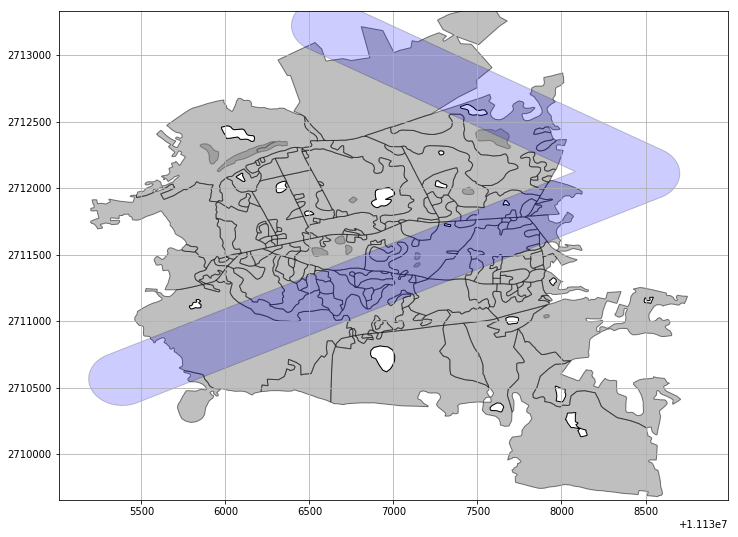

In [24]:
show(p,buf)

In [7]:
sc = pyspark.SparkContext()

# 标准流程：清洗过滤、计算、提交、可视化

### 1、过滤掉头，且进行清洗

In [25]:
def filterHeader(line):
    geoline = line.split("\t")
    try:
        return ogr.CreateGeometryFromWkt(geoline[1]).IsValid()
    except:
        return False

In [26]:
rdd = sc.textFile("../data/dltb.tsv").filter(lambda line : filterHeader(line))

### 2、进行空间选择，如果相交的，就选择出来

In [27]:
def SelectByLocation(line,selectGeom):
    return selectGeom.Intersects(ogr.CreateGeometryFromWkt(line.split("\t")[1]))

In [28]:
res = rdd.filter(lambda line : SelectByLocation(line,buf)).collect()

### 3、可视化

In [29]:
p2 = []
for pl in res:
    p2.append(ogr.CreateGeometryFromWkt(pl.split("\t")[1]))

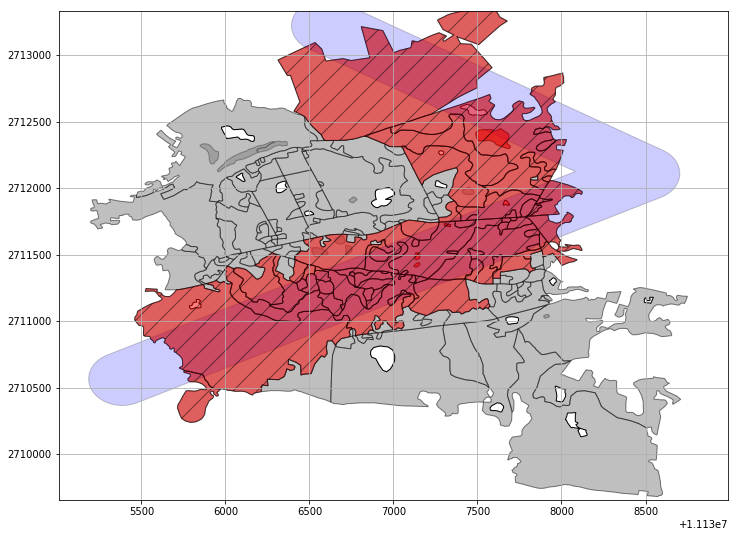

In [30]:
show(p,buf,p2)

## 选择出来的数据就是要进行clip的数据，筛选一下，可以有效的减少计算量，提高计算效率

In [31]:
filterRdd = rdd.filter(lambda line : SelectByLocation(line,buf))

## 裁切方法，用的相交算子，取出相交的部分来

In [32]:
def mapClip(line,buf):
    geo = ogr.CreateGeometryFromWkt(line.split("\t")[1])
    return (buf.Intersection(geo),1)

In [33]:
res = filterRdd.map(lambda line: mapClip(line,buf)).collect()

In [34]:
p2 = []
for pl in res:
    p2.append(pl[0])

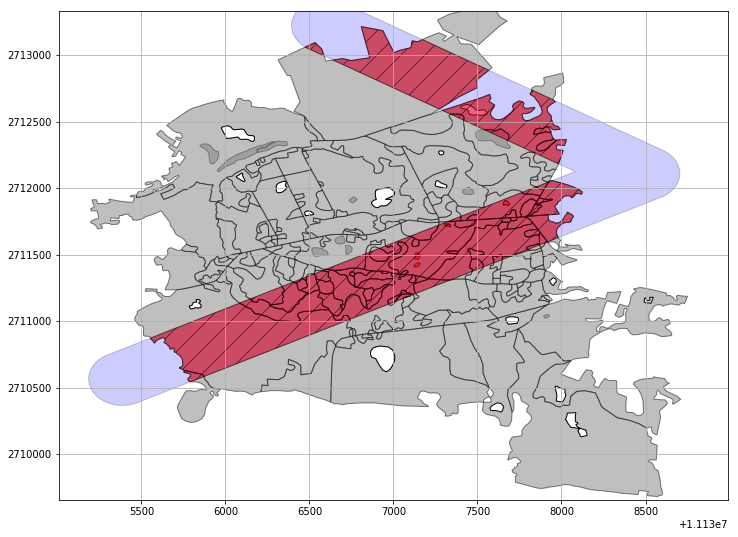

In [35]:
show(p,buf,p2)

## 单独画出分析的结果

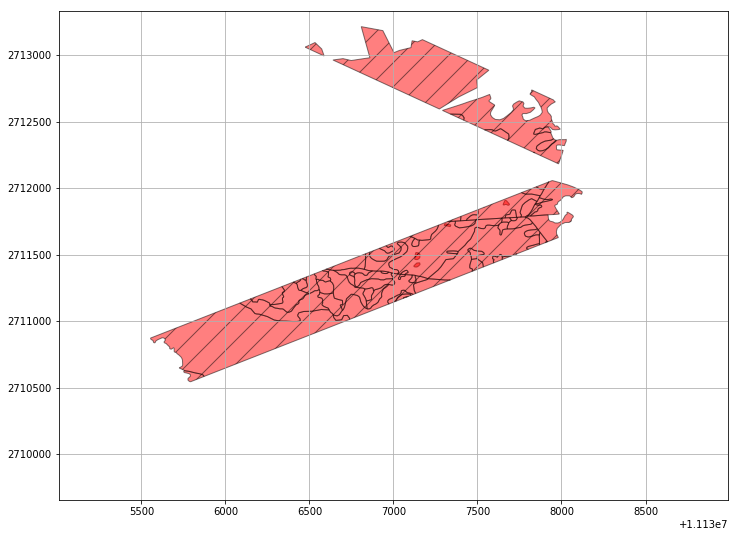

In [36]:
show([],[],p2)